# Density of observations/plots in climate space

We want to determine the distribution and density of the iNaturalist observations and the sPlotOpen vegetation plots in climate space, specifically temperature / percipitation space.

This section covers:

- Extract temperature and percipitation data from WorldClim 
- Plotting density in climate space

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
import cartopy.crs as ccrs
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd


In [ ]:
# open files
sPlot = pd.read_csv("sPlotOpen/cwm_loc.csv")

# open file with all iNaturalist observations and trait values
iNat = pd.read_csv("iNat_TRY_log.csv")


Convert to geodataframe, so that we can work with the geopandas geometry:

In [ ]:
geo_iNat = gpd.GeoDataFrame( iNat.iloc[:,:22], geometry=gpd.points_from_xy(iNat.decimalLongitude, iNat.decimalLatitude), 
                            crs='epsg:4326')

In [ ]:
geo_sPlot = gpd.GeoDataFrame(sPlot, geometry=gpd.points_from_xy(sPlot.Longitude, sPlot.Latitude), crs='epsg:4326')

## Extract temperature and percipitation data from WorldClim 

In [ ]:
# Open the raster of temperature and percipitation information

perc = rio.open('WorldClim/wc2.1_2.5m_bio_12.tif')
temp = rio.open('WorldClim/wc2.1_2.5m_bio_1.tif')


In [ ]:
#https://gis.stackexchange.com/questions/317391/python-extract-raster-values-at-point-locations

# Read points from shapefile
clim_sPlot = geo_sPlot
clim_sPlot = clim_sPlot[['Longitude', 'Latitude','PlotObservationID','geometry']]
clim_sPlot.index = range(len(clim_sPlot))
coords = [(x,y) for x, y in zip(clim_sPlot.Longitude, clim_sPlot.Latitude)]

# Sample the raster at every point location and store values in DataFrame
clim_sPlot['Perc'] = [x[0] for x in perc.sample(coords)]
clim_sPlot['Temp'] = [x[0] for x in temp.sample(coords)]



In [ ]:
# about 15 min

# Read points from shapefile
clim_iNat = iNat[['decimalLongitude', 'decimalLatitude','scientificName', 'eventDate']]
clim_iNat = clim_iNat[clim_iNat['decimalLongitude'].notna()]
clim_iNat = clim_iNat[clim_iNat['decimalLatitude'].notna()]
clim_iNat.index = range(len(clim_iNat))
coords = [(x,y) for x, y in zip(clim_iNat.decimalLongitude, clim_iNat.decimalLatitude)]

# Sample the raster at every point location and store values in DataFrame
clim_iNat['Perc'] = [x[0] for x in perc.sample(coords)]
clim_iNat['Temp'] = [x[0] for x in temp.sample(coords)]



### Save climate data

In [ ]:
clim_iNat.to_csv("iNat_climate_variables.csv", index=False)

In [ ]:
clim_sPlot.to_csv("sPlot_climate_variables.csv", index=False)

## Plot in climate space

In [4]:
# open files
clim_sPlot = pd.read_csv("sPlot_climate_variables.csv")
clim_iNat = pd.read_csv("iNat_climate_variables.csv")

In [5]:
# read Whittaker coordinates
# data taken from R package "plotbiomes": https://github.com/valentinitnelav/plotbiomes

Whittaker = pd.read_csv("Whittaker_biomes.csv")

In [6]:
Whittaker.head()

,temp_c,precp_cm,biome_id,biome
0,-10.216002,1.607134,6,Tundra
1,-10.628573,1.696938,6,Tundra
2,-11.141165,1.846052,6,Tundra
3,-11.617762,2.028094,6,Tundra
4,-12.059605,2.242129,6,Tundra


In [7]:
# change mm to cm
clim_iNat['Perc'] = clim_iNat['Perc'].div(10)
clim_sPlot['Perc'] = clim_sPlot['Perc'].div(10)

In [8]:
clim_sPlot

,Longitude,Latitude,PlotObservationID,geometry,Perc,Temp
0,-154.180000,62.420000,16,POINT (-154.18 62.42),42.8,-2.578834
1,-154.180000,62.420000,17,POINT (-154.18 62.42),42.8,-2.578834
2,-154.180000,62.420000,18,POINT (-154.18 62.42),42.8,-2.578834
3,-154.180000,62.420000,20,POINT (-154.18 62.42),42.8,-2.578834
4,-154.180000,62.420000,22,POINT (-154.18 62.42),42.8,-2.578834
...,...,...,...,...,...,...
95099,27.273862,56.287870,1126749,POINT (27.273862 56.28787),62.0,5.296333
95100,23.598014,56.939965,1126761,POINT (23.598014 56.939965),61.7,6.614500
95101,23.598014,56.939965,1126769,POINT (23.598014 56.939965),61.7,6.614500
95102,22.147667,57.248222,1126774,POINT (22.147667 57.248222),66.8,6.546000


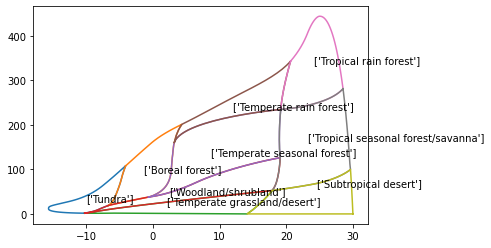

In [9]:
for b in Whittaker['biome_id'].unique():
    subplot = Whittaker[Whittaker['biome_id']==b]
    plt.plot(subplot['temp_c'], subplot['precp_cm'], '-')
    plt.text(subplot["temp_c"].mean(),subplot["precp_cm"].mean(),s=str(subplot["biome"].unique()))


Plot sPlotOpen in climate space:

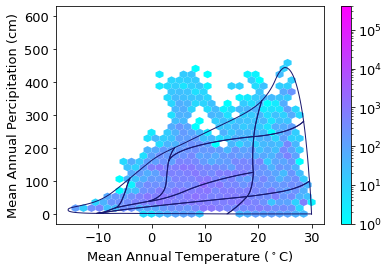

In [12]:
plt.rcParams.update({'font.size': 13})


ax1 = clim_sPlot.plot.hexbin(x='Temp', y='Perc', 
                            gridsize=30, 
                            extent=[-15,30,0,600], 
                            cmap="cool", 
                            mincnt=1, 
                            bins='log', 
                             sharex=False,
                             linewidths=0.1,
                             edgecolors=None,
                             vmax = 400000
                            )

plt.xlabel("Mean Annual Temperature ($^\circ$C)")
plt.ylabel("Mean Annual Percipitation (cm)")

# add Whittaker biome line
for b in Whittaker['biome_id'].unique():
    subplot = Whittaker[Whittaker['biome_id']==b]
    plt.plot(subplot['temp_c'], subplot['precp_cm'], '-', color="midnightblue", linewidth=1)

plt.savefig('../Figures/sPlot_density_climate_space_tight.pdf', bbox_inches='tight')  

Plot iNaturalist observations in climate space:

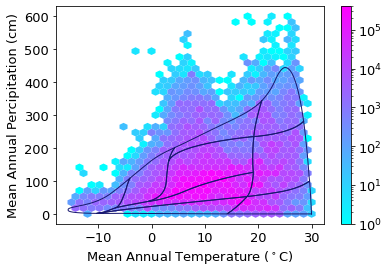

In [21]:
plt.rcParams.update({'font.size': 13})
ax2= clim_iNat.plot.hexbin(x='Temp', y='Perc', 
                           gridsize=30, 
                           extent=[-15,30,0,600], 
                           cmap="cool", 
                           mincnt=1, 
                           bins='log', 
                           sharex=False,
                            linewidths=0.1,
                            edgecolors=None,
                          vmax= 400000)
plt.xlabel("Mean Annual Temperature ($^\circ$C)")
plt.ylabel("Mean Annual Percipitation (cm)")

# add Whittaker biome line
for b in Whittaker['biome_id'].unique():
    subplot = Whittaker[Whittaker['biome_id']==b]
    plt.plot(subplot['temp_c'], subplot['precp_cm'], '-', color="midnightblue", linewidth=1)

plt.savefig('../Figures/iNat_density_climate_space_tight.pdf', bbox_inches='tight')  